#**PROJET 7 : Implémentez un modèle de scoring**

Source des données : sur [Kaggle - home credit default risk](https://www.kaggle.com/competitions/home-credit-default-risk/data)

L'objectif est d'implémenter un modèle de scoring pour définir ou aider à définir l'accord ou non d'un prêt à un client potentiel. Les différents fichiers récupérés pour cette étude (8 au total) informent sur les clients et leur situation financière actuelle (au niveau des prêts déjà effectués, des prêts en cours, etc.).  

Dans une première partie (cf. [I. Analyse et pré-traitement](https://colab.research.google.com/drive/14Uw_sc8GspwrewN5GC6QlRY9KN-px3On#scrollTo=I_Analyse_et_pr_traitement)), nous décrirons ces différents fichiers. Nous effectuerons une courte analyse exploratoire et un nettoyage de données pour préparer mieux le dataset que nous utiliserons dans une seconde partie (cf. [II. Modélisation](https://colab.research.google.com/drive/14Uw_sc8GspwrewN5GC6QlRY9KN-px3On#scrollTo=II_Mod_lisation)).

*Ce notebook a été créé et travaillé avec Google Collab.*

# **I. Analyse et pré-traitement**

## Préparation initiale du dataset

In [ ]:
# Connexion au drive
from google.colab import drive 
drive.mount('/content/drive/')

In [ ]:
!pip install featuretools

In [ ]:
# Importation des librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Feature engineering
import featuretools as ft
from featuretools import selection
import woodwork as ww

In [53]:
# Importation des données
path = "/content/drive/MyDrive/OC/Data/Data-P7/"
train_set = pd.read_csv(path+"application_train.csv")
test_set = pd.read_csv(path+"application_test.csv")
bureau = pd.read_csv(path+"bureau.csv")
bureau_balance = pd.read_csv(path+"bureau_balance.csv")
cash_balance = pd.read_csv(path+"POS_CASH_balance.csv")
card_balance = pd.read_csv(path+"credit_card_balance.csv")
prev_app = pd.read_csv(path+"previous_application.csv")
payments = pd.read_csv(path+"installments_payments.csv")

## Description des données

Il y a 8 fichiers au total :  
- 1 fichier principal pour la partie "training" importé dans ```train_set``` (1 ligne / prêt)
- 1 fichier principal pour la partie "test" importé dans ```test_set``` (1 ligne / prêt)
- 6 autres fichiers contenant des informations supplémentaires sur chaque prêt.

### Train/Test data

In [54]:
# Training data
print('Training data shape: ', train_set.shape)
train_set.describe()
train_set.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Testing data
print('Testing data shape: ', test_set.shape)
test_set.describe()
test_set.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
#print(train_set.columns.values)
#print(test_set.columns.values)

Le ``train_set`` est 6 fois plus imposant que le ``test_set`` et a une colone ``TARGET`` en plus qu'on tentera de prédire pour le ``test_set``.  

### Autres données

In [57]:
# Bureau
print('Bureau data shape: ', bureau.shape)
#print(bureau.describe())
bureau.head()

Bureau data shape:  (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [58]:
# Bureau balance
print('Bureau balance data shape: ', bureau_balance.shape)
#print(bureau_balance.describe())
bureau_balance.head()

Bureau balance data shape:  (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [59]:
# Cash balance
print('Cash balance data shape: ', cash_balance.shape)
#print(cash_balance.describe())
cash_balance.head()

Cash balance data shape:  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [60]:
# Card balance
print('Card balance data shape: ', card_balance.shape)
#print(card_balance.describe())
card_balance.head()

Card balance data shape:  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [61]:
# Previous applications balance
print('Previous applications data shape: ', prev_app.shape)
#print(prev_app.describe())
prev_app.head()

Previous applications data shape:  (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
# Payments balance
print('Payments data shape: ', payments.shape)
#print(payments.describe())
payments.head()

Payments data shape:  (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


## Exploration des données

### La variable ``TARGET`` à prédire

Sa valeur est soit de **0** quand le prêt a été remboursé dans les temps, soit de 1 quand le client a rencontré des difficultés de paiement.

In [63]:
# Fonction permettant d'afficher un pieplot sur la solvabilité clients
def solvability_clients(df):
    target_values = df['TARGET'].value_counts()/len(df)*100
    plt.pie(target_values,
            colors=['#2ecf00', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"])
    plt.show()

In [64]:
train_set['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

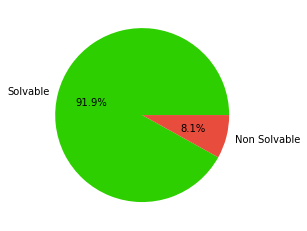

In [65]:
solvability_clients(train_set)

A partir de ces informations, nous voyons qu'il s'agit d'un problème de classe déséquilibré. Il y a beaucoup plus de prêts qui ont été remboursés à temps que de prêts qui n'ont pas été remboursés. Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes en fonction de leur représentation dans les données pour refléter ce déséquilibre.  

### Les valeurs manquantes

In [66]:
# Fonction qui calcule les valeurs manquantes par colone
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
           "There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [67]:
# Statistiques des valeurs manquantes
missing_values = missing_values_table(train_set)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


### Types des colonnes

In [68]:
# Nombre de chaque type de colonne
# float64 et int64 pour des variables numériques
# object pour des variables catégorielles
train_set.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [69]:
# Nombre des valeurs uniques pour les variables catégorielles
train_set.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégorielles a un faible nombre de valeurs uniques.

## Nettoyage des données

Pour faciliter le nettoyage de données pour les jeux de données Train et Test, nous allons concaténer ces deux ensembles avec l'ajout d'une colonne ``Test`` pour les differencier.

In [70]:
# Merge application data
train_set['Test'] = False
test_set['Test'] = True
test_set['TARGET'] = np.nan
app = train_set.append(test_set, sort=False)

In [71]:
app.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
5,100008,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,False
6,100009,0.0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,False
7,100010,0.0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
8,100011,0.0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
9,100012,0.0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False


In [72]:
app.sample(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
46888,154310,1.0,Cash loans,F,Y,Y,0,180000.0,787131.0,28404.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0,False
35945,363048,NaN,Cash loans,F,N,Y,1,67500.0,177768.0,10872.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
55753,164599,0.0,Cash loans,F,N,Y,0,112500.0,182286.0,17887.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,9.0,False
112086,230030,0.0,Revolving loans,F,N,Y,0,99000.0,337500.0,16875.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,False
259224,399999,0.0,Cash loans,F,N,Y,0,180000.0,326439.0,12433.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,False
13976,116294,0.0,Cash loans,F,N,N,0,85500.0,1506816.0,47313.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
21356,124882,0.0,Cash loans,F,Y,N,0,83700.0,454500.0,20020.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,False
7438,154442,NaN,Cash loans,F,N,Y,1,112500.0,420588.0,32679.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
130506,251372,0.0,Cash loans,M,N,N,0,315000.0,1035832.5,33412.5,...,0,0,0,0.0,0.0,0.0,6.0,0.0,3.0,False
14257,116629,0.0,Cash loans,F,N,Y,0,175500.0,1800000.0,62568.0,...,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0,False


In [73]:
# Sauvegarde des données non traités
app.to_csv('app_initial.csv')
!cp app_initial.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

### Similarité des variables Train / Test

**Variables catégorielles**

In [74]:
# Définition des valeurs uniques des variables catégorielles dans train_set ET test_set
for col in app:
    if app[col].dtype == object:
        print(col)
        print('Number Unique in Train:', app[~app['Test']][col].nunique())
        print('Number Unique in Test: ', app[app['Test']][col].nunique())
        print('Unique in Train: ',
              sorted([str(e) for e in
                      app[~app['Test']][col].unique().tolist()]))
        print('Unique in Test: ',
              sorted([str(e) for e in
                      app[app['Test']][col].unique().tolist()]))
        print('\n')

NAME_CONTRACT_TYPE
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['Cash loans', 'Revolving loans']
Unique in Test:  ['Cash loans', 'Revolving loans']


CODE_GENDER
Number Unique in Train: 3
Number Unique in Test:  2
Unique in Train:  ['F', 'M', 'XNA']
Unique in Test:  ['F', 'M']


FLAG_OWN_CAR
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


FLAG_OWN_REALTY
Number Unique in Train: 2
Number Unique in Test:  2
Unique in Train:  ['N', 'Y']
Unique in Test:  ['N', 'Y']


NAME_TYPE_SUITE
Number Unique in Train: 7
Number Unique in Test:  7
Unique in Train:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']
Unique in Test:  ['Children', 'Family', 'Group of people', 'Other_A', 'Other_B', 'Spouse, partner', 'Unaccompanied', 'nan']


NAME_INCOME_TYPE
Number Unique in Train: 8
Number Unique in Test:  7
Unique in Train:  ['Businessman', 'Commercial associate

Certaines variables catégorielles n'ont pas les mêmes choix de valeurs dans les deux jeux de données. Le ``CODE_GENDER``, le ``NAME_INCOME_TYPE`` et le ``NAME_FAMILY_STATUS`` ont une valeur de plus dans le ``train_set``. Ci-dessous, ont été supprimé les lignes comportant ces valeurs car elles ne représentent au total qu'une dizaine d'individus de l'échantillon.

``CODE_GENDER``

In [75]:
app[app['CODE_GENDER'] == 'XNA'].count()

SK_ID_CURR                    4
TARGET                        4
NAME_CONTRACT_TYPE            4
CODE_GENDER                   4
FLAG_OWN_CAR                  4
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    4
AMT_REQ_CREDIT_BUREAU_MON     4
AMT_REQ_CREDIT_BUREAU_QRT     4
AMT_REQ_CREDIT_BUREAU_YEAR    4
Test                          4
Length: 123, dtype: int64

In [76]:
# Suppression des individus dont le genre est "XNA"
app = app[app['CODE_GENDER'] != 'XNA']

``NAME_INCOME_TYPE``

In [77]:
app[app['NAME_INCOME_TYPE'] == 'Maternity leave'].count()

SK_ID_CURR                    5
TARGET                        5
NAME_CONTRACT_TYPE            5
CODE_GENDER                   5
FLAG_OWN_CAR                  5
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    1
AMT_REQ_CREDIT_BUREAU_MON     1
AMT_REQ_CREDIT_BUREAU_QRT     1
AMT_REQ_CREDIT_BUREAU_YEAR    1
Test                          5
Length: 123, dtype: int64

In [78]:
# Suppression des individus en congé maternité
app = app[app['NAME_INCOME_TYPE'] != 'Maternity leave']

``NAME_FAMILY_STATUS``

In [79]:
app[app['NAME_FAMILY_STATUS'] == 'Unknown'].count()

SK_ID_CURR                    2
TARGET                        2
NAME_CONTRACT_TYPE            2
CODE_GENDER                   2
FLAG_OWN_CAR                  2
                             ..
AMT_REQ_CREDIT_BUREAU_WEEK    1
AMT_REQ_CREDIT_BUREAU_MON     1
AMT_REQ_CREDIT_BUREAU_QRT     1
AMT_REQ_CREDIT_BUREAU_YEAR    1
Test                          2
Length: 123, dtype: int64

In [80]:
# Suppression des individus dont le statut familliale est inconnu
app = app[app['NAME_FAMILY_STATUS'] != 'Unknown']

**Variables numériques**.

``DAYS_EMPLOYED``

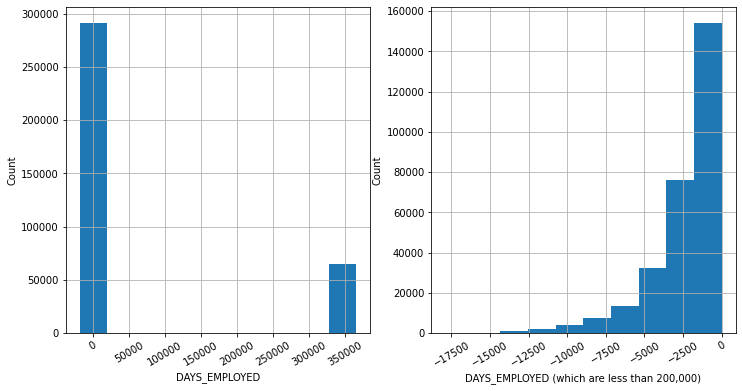

In [81]:
# Affiche l'histogramme du nombre de jours employés
fig = plt.figure(1, figsize=(12, 6))
plt.subplot(1, 2, 1)
app['DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED')
plt.ylabel('Count')
plt.xticks(rotation=30)

# Affiche l'histogramme pour les valeurs normales
plt.subplot(1, 2, 2)
app.loc[app['DAYS_EMPLOYED'] < 200000, 'DAYS_EMPLOYED'].hist()
plt.xlabel('DAYS_EMPLOYED (which are less than 200,000)')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.show()

In [82]:
# Affiche les valeurs abérrantes - train_set
values_to_nan = app.loc[app['DAYS_EMPLOYED'] > 366, 'DAYS_EMPLOYED'].unique()
print(values_to_nan)

[365243]


In [83]:
# Remplace la valeur abérrante par NaN - train_set
app['DAYS_EMPLOYED'].replace(values_to_nan, np.nan, inplace=True)

In [84]:
# Sauvegarde des résultats
app.to_csv("app_no_encoded_no_featureengineering.csv")
!cp app_no_encoded_no_featureengineering.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

In [85]:
app.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
5,100008,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,False
6,100009,0.0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,False
7,100010,0.0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
8,100011,0.0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
9,100012,0.0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False


In [86]:
app_temp = app.copy()

In [87]:
app = app_temp.copy()

In [88]:
app.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False


### Feature Engineering

La première étape de l'utilisation de Featuretools consiste à définir les "entités", chacune étant un fichier de données ou une table, et les colonnes le long desquelles elles sont indexées.

In [89]:
# Création d'un ensemble d'entités
es = ft.EntitySet(id='applications')

In [90]:
# Ajout des dataframes
es = es.add_dataframe(dataframe_name='applications',
                      dataframe=app,
                      make_index=False,
                      index='SK_ID_CURR')

In [91]:
es

Entityset: applications
  DataFrames:
    applications [Rows: 356244, Columns: 123]
  Relationships:
    No relationships

In [92]:
app.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
100003,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100004,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100006,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
100007,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100008,100008,0.0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0,False
100009,100009,0.0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0,False
100010,100010,0.0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100011,100011,0.0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
100012,100012,0.0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False


In [93]:
# Affichage du type de chaque colonne
es['applications']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
100003,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100004,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100006,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
100007,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
456222,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
456223,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,True
456224,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,True


Il semble que certains types de données soient incorrects. La plupart des colonnes ``FLAG_*`` doivent être booléennes et non numériques. Nous définirons manuellement le type de données de certaines colonnes. Mis à part le type de données booléen, il existe également des types de données Index, Datetime, Numeric, Text, etc.

In [ ]:
# Featuretools datatypes
BOOL = ww.logical_types.Boolean

# Définition manuelle des datatypes
variable_types = {
    'FLAG_MOBIL': BOOL,
    'FLAG_EMP_PHONE': BOOL,
    'FLAG_WORK_PHONE': BOOL,
    'FLAG_CONT_MOBILE': BOOL,
    'FLAG_PHONE': BOOL,
    'FLAG_EMAIL': BOOL,
    'REG_REGION_NOT_LIVE_REGION': BOOL,
    'REG_REGION_NOT_WORK_REGION': BOOL,
    'LIVE_REGION_NOT_WORK_REGION': BOOL,
    'REG_CITY_NOT_LIVE_CITY': BOOL,
    'REG_CITY_NOT_WORK_CITY': BOOL,
    'LIVE_CITY_NOT_WORK_CITY': BOOL,
    'FLAG_DOCUMENT_2': BOOL,
    'FLAG_DOCUMENT_3': BOOL,
    'FLAG_DOCUMENT_4': BOOL,
    'FLAG_DOCUMENT_5': BOOL,
    'FLAG_DOCUMENT_6': BOOL,
    'FLAG_DOCUMENT_7': BOOL,
    'FLAG_DOCUMENT_8': BOOL,
    'FLAG_DOCUMENT_9': BOOL,
    'FLAG_DOCUMENT_10': BOOL,
    'FLAG_DOCUMENT_11': BOOL,
    'FLAG_DOCUMENT_12': BOOL,
    'FLAG_DOCUMENT_13': BOOL,
    'FLAG_DOCUMENT_14': BOOL,
    'FLAG_DOCUMENT_15': BOOL,
    'FLAG_DOCUMENT_16': BOOL,
    'FLAG_DOCUMENT_17': BOOL,
    'FLAG_DOCUMENT_18': BOOL,
    'FLAG_DOCUMENT_19': BOOL,
    'FLAG_DOCUMENT_20': BOOL,
    'FLAG_DOCUMENT_21': BOOL,
}

# Ajout de app dans es en utilisant les datatypes définits manuellement
es = es.add_dataframe(dataframe_name='applications',
                      dataframe=app,
                      index='SK_ID_CURR',
                      logical_types=variable_types)

In [95]:
# Affichage du type de chaque colonne
es['applications']

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
100003,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100004,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
100006,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
100007,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456221,456221,NaN,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
456222,456222,NaN,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
456223,456223,NaN,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,True
456224,456224,NaN,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,True


In [ ]:
# Featuretools datatypes
ID = ww.logical_types.Integer

# Ajout de bureau dans es
es = es.add_dataframe(
    dataframe_name='bureau',
    dataframe=bureau,
    index='SK_ID_BUREAU',
    logical_types={'SK_ID_CURR': ID})

# Ajout de bureau_balance dans es
es = es.add_dataframe(
    dataframe_name='bureau_balance',
    dataframe=bureau_balance,
    index='New',
    logical_types={'SK_ID_BUREAU': ID})

# Ajout de cash_balance dans es
es = es.add_dataframe(
    dataframe_name='cash_balance',
    dataframe=cash_balance,
    index='New',
    logical_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})

# Ajout de card_balance dans es
es = es.add_dataframe(
    dataframe_name='card_balance',
    dataframe=card_balance,
    index='New',
    logical_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})
                              
# Ajout de prev_app dans es
es = es.add_dataframe(
    dataframe_name='prev_app',
    dataframe=prev_app,
    index='SK_ID_PREV',
    logical_types={'SK_ID_CURR': ID,
                    'NFLAG_LAST_APPL_IN_DAY': BOOL})

# Ajout de payments dans es
es = es.add_dataframe(
    dataframe_name='payments',
    dataframe=payments,
    index='New',
    logical_types={'SK_ID_PREV': ID,
                    'SK_ID_CURR': ID})

In [97]:
es

Entityset: applications
  DataFrames:
    applications [Rows: 356244, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash_balance [Rows: 10001358, Columns: 9]
    card_balance [Rows: 3840312, Columns: 24]
    prev_app [Rows: 1670214, Columns: 37]
    payments [Rows: 13605401, Columns: 9]
  Relationships:
    No relationships

La prochaine étape est de définir les relations entre ces entités.

In [98]:
# Définition des relations entre les dataframes
relationships = [
  # parent_entity   parent_variable  child_entity      child_variable
  ('applications', 'SK_ID_CURR',    'bureau',         'SK_ID_CURR'),
  ('bureau',       'SK_ID_BUREAU',  'bureau_balance', 'SK_ID_BUREAU'),
  ('applications', 'SK_ID_CURR',    'prev_app',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'cash_balance',   'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'payments',       'SK_ID_CURR'),
  ('applications', 'SK_ID_CURR',    'card_balance',   'SK_ID_CURR')
]

# Création des relations dans es
for pe, pv, ce, cv in relationships:
    es = es.add_relationship(pe, pv, ce, cv)

In [99]:
es

Entityset: applications
  DataFrames:
    applications [Rows: 356244, Columns: 123]
    bureau [Rows: 1716428, Columns: 17]
    bureau_balance [Rows: 27299925, Columns: 4]
    cash_balance [Rows: 10001358, Columns: 9]
    card_balance [Rows: 3840312, Columns: 24]
    prev_app [Rows: 1670214, Columns: 37]
    payments [Rows: 13605401, Columns: 9]
  Relationships:
    bureau.SK_ID_CURR -> applications.SK_ID_CURR
    bureau_balance.SK_ID_BUREAU -> bureau.SK_ID_BUREAU
    prev_app.SK_ID_CURR -> applications.SK_ID_CURR
    cash_balance.SK_ID_CURR -> applications.SK_ID_CURR
    payments.SK_ID_CURR -> applications.SK_ID_CURR
    card_balance.SK_ID_CURR -> applications.SK_ID_CURR

In [ ]:
"""# Liste des primitives disponible dans Featuretools
pd.options.display.max_rows = 100
ft.list_primitives()"""

# TODO [WIP] : Avec primitives.
# Problème : Session plantée avec l'ajout des primitives dans es

In [ ]:
"""# Définition des primitives à utiliser
agg_primitives = ['count', 'mean']
trans_primitives = ['cum_sum']

# Ajout des primitives dans es
app, dfs_defs = ft.dfs(entityset=es,
                            target_dataframe_name='applications',
                            trans_primitives=trans_primitives,
                            agg_primitives=agg_primitives, 
                            #verbose=True,
                            #max_depth=2, n_jobs=2) """

# TODO [WIP] : Avec primitives.
# Problème : Session plantée avec l'ajout des primitives dans es

In [102]:
app.columns.tolist()

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [103]:
# Suppression des features qui ne donnent pas d'informations
app = selection.remove_low_information_features(app)
print("Le nombre de colonnes est de {}".format(len(app.columns)))

Le nombre de colonnes est de 123


In [104]:
# Ajout de features potentiellement utiles pour notre modèle

# Le ratio temps travaillé / âge
app['PROPORTION_LIFE_EMPLOYED'] = app['DAYS_EMPLOYED'] / app['DAYS_BIRTH']

# Le ratio crédit / revenu
app['INCOME_TO_CREDIT_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_CREDIT'] 

# Le ratio revenu / paiement annuel (annuité)
app['INCOME_TO_ANNUITY_RATIO'] = app['AMT_INCOME_TOTAL'] / app['AMT_ANNUITY']

# Le ratio revenu / annuité / âge
app['INCOME_TO_ANNUITY_RATIO_BY_AGE'] = app['INCOME_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']

# Le ratio crédit / annuité
app['CREDIT_TO_ANNUITY_RATIO'] = app['AMT_CREDIT'] / app['AMT_ANNUITY']

# Le ratio crédit / annuité / âge
app['CREDIT_TO_ANNUITY_RATIO_BY_AGE'] = app['CREDIT_TO_ANNUITY_RATIO'] * app['DAYS_BIRTH']

# Le ratio revenu / taille de la famille
app['INCOME_TO_FAMILYSIZE_RATIO'] = app['AMT_INCOME_TOTAL'] / app['CNT_FAM_MEMBERS']

In [105]:
# Sauvegarde des résultats
app.to_csv("app_no_enconded_featureengineering.csv")
!cp app_no_enconded_featureengineering.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

### Traitement des valeurs manquantes

Nous procéderons par la proportion de valeurs manquantes. Si une variable a **plus de 10%** de valeurs manquantes, elle sera supprimée.

In [106]:
# Fonction qui calcul la proportion de données manquantes
def missing_values(df, display=False, printf=True, top_n_missing=30, title=""): 
    
    # Calcul de la proportion de données manquantes pour chaque colonne
    null_prop = df.isnull().sum(axis=0).sum()/len(df)/len(df.columns)*100
    null = df.isnull().sum(axis=0).sort_values()/len(df)*100
    
    if printf:
        print("Le pourcentage moyen de valeurs manquantes est de {:.2f}%".format(null_prop))
    
    # Si display=True, plot :
    if display :
        fig = plt.figure(figsize=(14, 6))
        plt.axhline(y=null_prop, color='k', linestyle='--', lw=2)
        plt.legend(['{:.2f}% global de données manquantes'.format(null_prop)], fontsize=13)

        data_to_plot = pd.DataFrame(null).sort_values(by = 0, ascending=False)[0: top_n_missing]
        
        sns.barplot(data_to_plot.index, data_to_plot[0])
        plt.ylabel("%")
        plt.title(title)
        labels = ['\n'.join(wrap(l, top_n_missing)) for l in data_to_plot.index]        
        plt.xticks(range(len(labels)), labels, rotation='vertical')
        
        plt.show()
    else :
        return null

In [107]:
# Proportion des valeurs manquantes
miss_val = missing_values(app)

# Suppression des colonnes dont les valeurs manquantes sont > 10%
list_miss_val = list(miss_val[miss_val > 90].index)
app.drop(columns=list_miss_val, inplace=True)

Le pourcentage moyen de valeurs manquantes est de 23.18%


In [108]:
print('Le nouveau pourcentage de valeurs manquantes est de {:.2f}%'.format(
    app.isnull().sum(axis=0).sum()/len(app)/len(app.columns)*100))

Le nouveau pourcentage de valeurs manquantes est de 23.18%


In [109]:
# Sauvegarde des résultats
app.to_csv("app_no_enconded_featureengineering_missing_value.csv")
!cp app_no_enconded_featureengineering_missing_value.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

### Encodage des variables catégorielles

**Encodage des variables temporelles**

La variable ``WEEKDAY_APPR_PROCESS_START`` contient des informations sur le jour de la semaine. Il nous faut encoder la variable en deux dimensions en utilisant un système de coordonnées polaires. Cela limite le nombre de dimensions.

In [110]:
def polar_projection(app, col):

    # Create map from categories to polar projection
    DOW_map = {
        'MONDAY':    0,
        'TUESDAY':   1,
        'WEDNESDAY': 2,
        'THURSDAY':  3,
        'FRIDAY':    4,
        'SATURDAY':  5,
        'SUNDAY':    6,
    }
    DOW_map1 = {k: np.cos(2*np.pi*v/7.0) for k, v in DOW_map.items()}
    DOW_map2 = {k: np.sin(2*np.pi*v/7.0) for k, v in DOW_map.items()}

    # Show encoding of days of week -> circle
    days = ['MONDAY', 'TUESDAY', 'WEDNESDAY', 'THURSDAY', 'FRIDAY', 'SATURDAY', 'SUNDAY']
    tt = np.linspace(0, 2*np.pi, 200)
    xx = np.cos(tt)
    yy = np.sin(tt)
    plt.plot(xx, yy)
    plt.gca().axis('equal')
    plt.xlabel('Encoded Dimension 1')
    plt.ylabel('Encoded Dimension 2')
    plt.title('2D Projection of days of the week')
    for day in days:
        plt.text(DOW_map1[day], DOW_map2[day], day, ha='center')
    plt.show()
    
    # WEEKDAY_APPR_PROCESS_START to polar coords
    app[col + '_1'] = app[col].map(DOW_map1)
    app[col + '_2'] = app[col].map(DOW_map2)
    app.drop(columns=col, inplace=True)
    
    return app

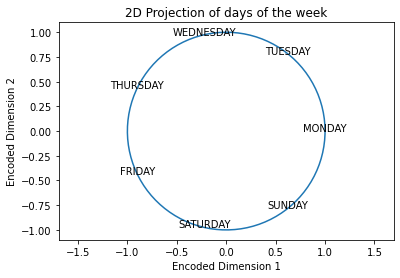

In [111]:
app = polar_projection(app, col='WEEKDAY_APPR_PROCESS_START')

In [112]:
app.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,Test,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,False,0.067329,0.498036,8.198215,-77563.308435,16.461104,-155738.505192,202500.0,-0.222521,0.974928
100003,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,False,0.070862,0.208736,7.563343,-126799.445355,36.234085,-607464.442834,135000.0,1.000000,0.000000
100004,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,False,0.011814,0.500000,10.000000,-190460.000000,20.000000,-380920.000000,67500.0,1.000000,0.000000
100006,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,False,0.159905,0.431748,4.547522,-86425.648022,10.532818,-200176.205093,67500.0,-0.222521,0.974928
100007,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,False,0.152418,0.236842,5.556699,-110756.122659,23.461618,-467636.962338,121500.0,-0.900969,0.433884


In [113]:
app = app.astype({'WEEKDAY_APPR_PROCESS_START_1': np.float64, 'WEEKDAY_APPR_PROCESS_START_2': np.float64})

**Encodage avec 'One-hot Encoder' / 'Label Encoder'**

Si une variable n'a que deux choix de valeurs, nous utiliserons ``LabelEncoder``. Si une variable a plus de deux choix de valeurs, nous utiliserons ``OneHotEncoder``.

In [114]:
def cat_encoder(app):

    # Label encoder
    label_encoder = LabelEncoder()
    
    # categorials features to one hot encode
    cat_features = []
    col_to_del = []

    for col in app.columns: 
        if col != 'Test' and col != 'TARGET':
            # Add indicator columns for empty values
            app_null = app[col].isnull()
            if app_null.sum() > 0:
                app[col + '_ISNULL'] = app_null
                col_to_del.append(col + '_ISNULL')

            #if app[col].dtype == 'bool' or app[col].dtype == object or app[col].dtype == 'category' :
            if app[col].dtype == object or app[col].dtype == 'category': 
                # Label encode binary fearures in training set
                if app[col].nunique() == 2:
                    if col + '_ISNULL' in app.columns:  # missing values here?
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                    app[col] = label_encoder.fit_transform(app[col])
                    if col + '_ISNULL' in app.columns:  # re-remove missing vals
                        app.loc[app[col + '_ISNULL'], col] = np.nan
                # get colunms to one hot encode
                elif app[col].nunique() > 2:
                    cat_features.append(col)

    # One-hot encode categorical features in train set
    app = pd.get_dummies(app, columns=cat_features)
    
    # Suppresion des colonnes nulles          
    app.drop(columns=col_to_del, inplace=True)
    
    return app

In [ ]:
# Encondage des variables catégorielles
app_enc = cat_encoder(app)

In [116]:
# Vérification de l'encodage des variables catégorielles
app_enc.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('bool'), dtype('uint8')],
      dtype=object)

In [117]:
app_enc.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
100002,100002,1.0,0,1,0,1,0,202500.0,406597.5,24700.5,...,1,0,0,0,0,0,0,0,1,0
100003,100003,0.0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,1,0,0,1,0,0,0,0,0,0
100004,100004,0.0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
100006,100006,0.0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
100007,100007,0.0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0
100008,100008,0.0,0,1,0,1,0,99000.0,490495.5,27517.5,...,0,0,0,0,0,0,0,0,0,0
100009,100009,0.0,0,0,1,1,1,171000.0,1560726.0,41301.0,...,0,0,0,0,0,0,0,0,0,0
100010,100010,0.0,0,1,1,1,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0,0,0,0,0,0
100011,100011,0.0,0,0,0,1,0,112500.0,1019610.0,33826.5,...,0,0,0,0,0,0,0,0,0,0
100012,100012,0.0,1,1,0,1,0,135000.0,405000.0,20250.0,...,0,0,0,0,0,0,0,0,0,0


## Sauvegarde des données

In [118]:
# Sauvegarde des données pré-traités
app_enc.to_csv('app_encoded.csv')
!cp app_encoded.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

# **II. Modélisation**

In [ ]:
# Connexion au drive
from google.colab import drive 
drive.mount('/content/drive/')

# Importation des librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importation des données
path = "/content/drive/MyDrive/OC/Data/Data-P7/"
app_enc = pd.read_csv(path+"app_encoded.csv", sep=',', index_col=0, encoding='utf8')
app = pd.read_csv(path+"app_no_enconded_featureengineering_missing_value.csv", sep=',', index_col=0, encoding='utf8')

In [2]:
app_enc.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
100002,100002,1.0,0,1,0,1,0,202500.0,406597.5,24700.5,...,1,0,0,0,0,0,0,0,1,0
100003,100003,0.0,0,0,0,0,0,270000.0,1293502.5,35698.5,...,1,0,0,1,0,0,0,0,0,0
100004,100004,0.0,1,1,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
100006,100006,0.0,0,0,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
100007,100007,0.0,0,1,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


In [3]:
app.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,1.0,False,0.067329,0.498036,8.198215,-77563.308435,16.461104,-155738.505192,202500.0
100003,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0.0,0.0,False,0.070862,0.208736,7.563343,-126799.445355,36.234085,-607464.442834,135000.0
100004,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0.0,0.0,False,0.011814,0.500000,10.000000,-190460.000000,20.000000,-380920.000000,67500.0
100006,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,NaN,NaN,False,0.159905,0.431748,4.547522,-86425.648022,10.532818,-200176.205093,67500.0
100007,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0.0,0.0,False,0.152418,0.236842,5.556699,-110756.122659,23.461618,-467636.962338,121500.0


In [ ]:
!pip install lime

In [5]:
# Importation des librairies

# Packages pour les tranformations de variables
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

# Packages de cross_validation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split

# Modèles de ML
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.linear_model import ElasticNet

from lime.lime_tabular import LimeTabularExplainer
from sklearn.neighbors import NearestNeighbors

# Metrics de ML
from sklearn.metrics import auc, roc_curve, roc_auc_score, make_scorer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Packages hyperopt pour la séléction d'hyperparamètres
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

# Package pour augmenter la data
from imblearn.over_sampling import SMOTE

# Sauvegarde des modèles
import pickle

## Sélection d'un modèle

### Préparation des données pour la modélisation

In [6]:
# Récupération des jeux de données Train / Test
train_set = app_enc.loc[~app_enc['Test'], :]
test_set = app_enc.loc[app_enc['Test'], :]

# Vérification du type des variables
train_set = train_set.astype(np.float64)
train_set.drop(columns=["Test"], inplace=True)
test_set = test_set.astype(np.float64)
test_set.drop(columns=["Test"], inplace=True)

# Variables cibles Train / Test
y_train = train_set['TARGET']
y_test = test_set['TARGET']

# Suppression des variables cibles dans les Train / Test
x_train = train_set.drop(columns=['TARGET'])
x_test = test_set.drop(columns=['TARGET'])

In [7]:
# Pipeline de standardisation et d'imputation des valeurs manquantes
var_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler()),
])

In [8]:
# Séparation du jeu d'entraînement en Train / Test
train_set, valid_set = train_test_split(train_set, test_size=0.2, random_state=42)

In [9]:
# Dictionnaire de classifieurs 
classifiers_1 = { 'Dummy Classifier': DummyClassifier(),
                  #'Logistic Regression': LogisticRegression(max_iter=100),
                  'Random Forest': RandomForestClassifier(n_estimators=100),
                  #'Multi-layer Perceptron': MLPClassifier(),
                  'Xgboost': XGBClassifier(),
                  'LGBM': LGBMClassifier() }

In [10]:
# Pipeline de transformation + classification
def define_pipeline(preprocessor, classifier) :
    pipe = Pipeline([("preprocess", preprocessor),
                     ("regressor", classifier)])
    return pipe

### Test des différents modèles de ML

In [48]:
# Fonction permettant d'afficher les courbes ROC des différents classifieurs
def plot_roc_curve(classifiers, var_pipeline, X, y, n_splits=5, fit=True):

    kf = KFold(n_splits=n_splits)
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for i, (train, test) in enumerate(kf.split(X, y)):

            full_pipeline = define_pipeline(var_pipeline, clf)
            
            if fit :
                full_pipeline.fit(X.iloc[train, :], y.iloc[train])

            y_pred_grd = full_pipeline.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + r'(AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Dummy Classifier
Random Forest
Xgboost
LGBM


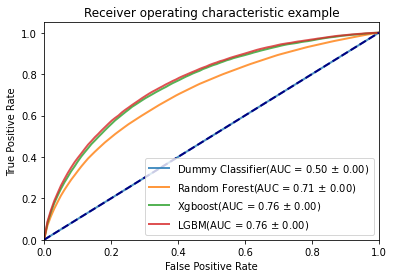

In [49]:
plot_roc_curve(classifiers_1, var_pipeline, train_set.drop(columns="TARGET"), train_set["TARGET"])

## Optimisation

In [11]:
skf = StratifiedKFold(n_splits=5)
def model_v1(predictor, pipeline, features, eval_metric, cv=skf):
    
    # Extract the ids
    train_ids = features.index

    # Extract the targets for training
    targets = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns=['TARGET'])
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Apply the pipeline
    features = pipeline.fit_transform(features)
    targets = np.array(targets)    
    
    # Increase the data to get a bigger proportion of positif targets
    sm = SMOTE(random_state=42, sampling_strategy=0.2) # the ratio is chosen
    # to correspond to the pareto law with the 80%/20% ratio
    features_res, targets_res = sm.fit_resample(features, targets.ravel())  

    def optim_score(params,
                    model=predictor,
                    x_train=features_res,
                    y_train=targets_res,
                    cv=cv,
                    eval_metric=eval_metric):

        # the function gets a set of variable parameters in "param"
        params_model = {'n_estimators': int(params['n_estimators']), 
                        'max_depth': int(params['max_depth']), 
                        'learning_rate': params['learning_rate'],
                        'subsample': params['subsample'],
                        'colsample_bytree': params['colsample_bytree'],
                        'num_leaves': int(params['num_leaves']),
                        'reg_alpha': params['reg_alpha'],
                        'reg_lambda': params['reg_lambda'],
        }

        # Asssigne les paramètres du modèle
        model.set_params(**params_model)
        
        # Seuil de solvabilité
        threshold = params['solvability_threshold']

        # Cross-validation à 5 passes : retourne le score de probabilité
        y_proba = cross_val_predict(model,
                                    x_train,
                                    y_train,
                                    method='predict_proba',
                                    cv=cv)[:, 1]
       
        # Si proba > seuil alors la prédiction est positive : 1
        y_pred = (y_proba > threshold)
        y_pred = np.array(y_pred > 0) * 1
        
        # Calcul du score suivant la métrique utilisé
        score = eval_metric(y_train, y_pred)

        return 1 - score # Retourne le score

    # possible values of parameters
    space={'n_estimators': hp.quniform('n_estimators', 200, 2000, 200),
           'max_depth' : hp.quniform('max_depth', 2, 5, 30),
           'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
           'subsample': hp.quniform('subsample', 0.1, 1.0, 0.2),
           'colsample_bytree': hp.quniform('colsample_by_tree', 0.6, 1.0, 0.1),
           'num_leaves': hp.quniform('num_leaves', 4, 100, 4),
           'reg_alpha': hp.quniform('reg_alpha', 0.1, 1.0, 0.1),
           'reg_lambda': hp.quniform('reg_lambda', 0.1, 1.0, 0.1),
           'solvability_threshold': hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)
    }

    best=fmin(fn=optim_score, # function to optimize
              space=space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=10, # maximum number of iterations
    )

    # Calculer le score sur les données test
    predictor.set_params(
        n_estimators=int(best['n_estimators']),
        max_depth=int(best['max_depth']),
        learning_rate=best['learning_rate'],
        subsample=best['subsample'],
        colsample_bytree=best['colsample_by_tree'],
        num_leaves=int(best['num_leaves']),
        reg_alpha=best['reg_alpha'],
        reg_lambda=best['reg_lambda'],
        )
    
    # Entrainement du modèle sur tout le jeu de données
    predictor.fit(features, targets)

    # Récupérer les meilleurs paramètres
    best_parameters = best
    
    # Assemblage de pipeline
    full_pipeline = define_pipeline(pipeline, predictor)

    # Récupérer l'importance des features
    feature_importance_values = full_pipeline[-1].feature_importances_
    
    # Feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names,
                                        'importance': feature_importance_values})

    return best_parameters, feature_importances, full_pipeline

In [12]:
def gain_seuil(clf, y_set, x_set):
    """
    Evolution du gain en fonction du seuil de solvabilité fixé
    Si score < seuil : client solvable
    Sinon : client non solvable
    """
    cost_function = []
    threshold_x = np.linspace(0.0, 1, 20)
    
    for threshold in threshold_x:
        
        # Score du modèle : 0 à 1
        y_scores = clf.predict_proba(x_set)[:, 1]
        
        # Score > seuil de solvabilité : retourne 1 sinon 0
        y_pred = (y_scores > threshold)
        
        y_pred = np.array(y_pred > 0) * 1
        # Calcul de l'indice bancaire
        cost_function.append(Ind_bank(y_set, y_pred))
        
    # Affichage du gain en fonction du seuil de solvabilité    
    plt.plot(threshold_x, cost_function)
    plt.xlabel("Seuil de probabilité")
    plt.ylabel("Indice banquaire")
    plt.xticks(np.linspace(0.1, 1, 10))

### Métrique banking

In [13]:
def Ind_bank(y_true, y_pred, fn_value=-10, fp_value=0, tp_value=0, tn_value=1):

    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    tp = mat_conf[1, 1]
    
    # Gain total
    J = tp*tp_value + tn*tn_value + fp*fp_value + fn*fn_value
    
    # Gain maximum
    max_J = (fp + tn)*tn_value + (fn + tp)*tp_value
    
    # Gain minimum
    min_J = (fp + tn)*fp_value + (fn + tp)*fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J)/(max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

In [14]:
# Optimisation pour la métrique 'Ind_bank'
best_parameters_0, feature_importance_0, clf_0 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          train_set.drop(columns=['SK_ID_CURR']),
                                                          eval_metric=Ind_bank)

# Affichage des meilleurs hyper-paramètres
best_parameters_0

100%|██████████| 10/10 [2:41:28<00:00, 968.86s/it, best loss: 0.22391884503899928]


{'colsample_by_tree': 0.8,
 'learning_rate': 0.022417173924480838,
 'max_depth': 0.0,
 'n_estimators': 1800.0,
 'num_leaves': 52.0,
 'reg_alpha': 0.4,
 'reg_lambda': 0.30000000000000004,
 'solvability_threshold': 0.07500000000000001,
 'subsample': 0.6000000000000001}

In [15]:
# Sauvegarde du modèle
filename = '/content/drive/MyDrive/OC/Data/Data-P7/banking_model.pkl'
pickle.dump(clf_0, open(filename, 'wb'))

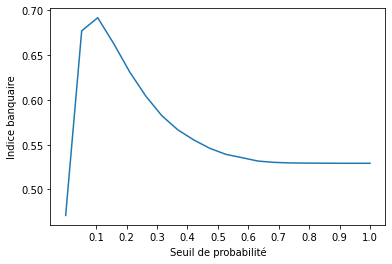

In [17]:
# Affiche le meilleur seuil de probabilité
gain_seuil(clf_0, valid_set["TARGET"], valid_set.drop(columns=["TARGET", 'SK_ID_CURR']))

### Métrique f1_score

In [18]:
# Optimisation pour la métrique 'roc_auc'
best_parameters_1, feature_importance_1, clf_1 = model_v1(LGBMClassifier(),
                                                          var_pipeline,
                                                          train_set.drop(columns=['SK_ID_CURR']),
                                                          eval_metric=f1_score)

# Affichage des meilleurs hyper-paramètres
best_parameters_1

100%|██████████| 10/10 [2:20:43<00:00, 844.33s/it, best loss: 0.28680098391889775]


{'colsample_by_tree': 0.9,
 'learning_rate': 0.044061645532195604,
 'max_depth': 0.0,
 'n_estimators': 1200.0,
 'num_leaves': 80.0,
 'reg_alpha': 0.7000000000000001,
 'reg_lambda': 0.6000000000000001,
 'solvability_threshold': 0.75,
 'subsample': 0.2}

In [19]:
# Sauvegarde du modèle
filename = '/content/drive/MyDrive/OC/Data/Data-P7/f1_model.pkl'
pickle.dump(clf_1, open(filename, 'wb'))

### Comparaison des résultats des deux métriques

In [20]:
# Fonction permettant d'afficher plusieurs matrices de confusions 
# en fonction des différentes prédictions
def plot_heatmap_confusion(y_valid, **y_valid_pred):
    
    plt.figure(1, figsize=(12, 4))
    results = {}
    
    j = 1
    for i, y_pred in y_valid_pred.items():
        
        plt.subplot(1, len(y_valid_pred), j)

        conf_mx = confusion_matrix(y_valid, y_pred)
        results[i] = conf_mx
        mat_conf_df = pd.DataFrame(conf_mx,
                                   columns=["Solvable", "Non Solvable"],
                                   index=["Solvable", "Non Solvable"])
        
        sns.heatmap(mat_conf_df, annot=True, linewidths=.7, fmt='g')

        plt.title(i)
        plt.ylim(0, 2)
        plt.xlabel("Classes prédites")
        plt.ylabel("Classes réelles")
        j+=1
    plt.show()
    
    return results

In [22]:
# Prédiction sur les données de validation avec banking
y_proba_0 = clf_0.predict_proba(valid_set.drop(columns=["TARGET", 'SK_ID_CURR']))[:, 1]
y_pred_0 = (y_proba_0 > best_parameters_0['solvability_threshold'])
y_pred_0 = np.array(y_pred_0 > 0) * 1

In [23]:
# Prédiction sur les données de validation avec f1_score
y_proba_1 = clf_1.predict_proba(valid_set.drop(columns=["TARGET", 'SK_ID_CURR']))[:, 1]
y_pred_1 = (y_proba_1 > best_parameters_1['solvability_threshold'])
y_pred_1 = np.array(y_pred_1 > 0) * 1

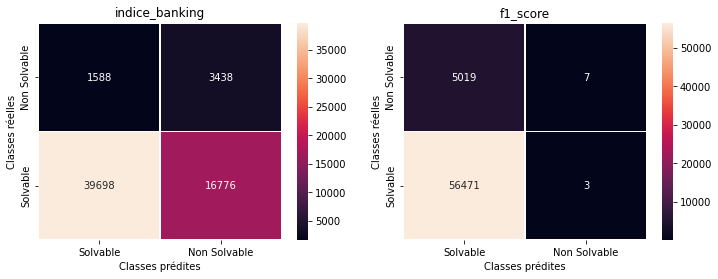

In [24]:
# Affichage des matrices de confusions pour les 2 métriques
mat_conf = plot_heatmap_confusion(valid_set["TARGET"],
                                  **{"indice_banking": y_pred_0, 
                                     "f1_score": y_pred_1})

In [25]:
# Calcule du gain pour la métrique bancaire
J_0 = Ind_bank(valid_set["TARGET"], y_pred_0)
# Calcul du gain pour la métrique métier
J_1 = Ind_bank(valid_set["TARGET"], y_pred_1)
print("Le gain normalisé pour la métrique banking est de {:.2f} alors qu'il est de {:.2f} pour la métrique technique"
      .format(J_0, J_1))
print("La création de la métrique banking permet un gain de {:.1f}%".format(100*(J_0 - J_1)/J_0))

Le gain normalisé pour la métrique banking est de 0.69 alors qu'il est de 0.53 pour la métrique technique
La création de la métrique banking permet un gain de 23.7%


### Précisions, rappel, roc_auc

In [26]:
def calculate_multi_metrics(clf, x_valid, y_valid, threshold, *metrics):
   
    # liste des scores
    scores = []
    
    # calcule de la probabilité retourné par le modèle
    valid_proba = clf.predict_proba(x_valid)[:, 1]
    # calcule de la prédiction en fonction du threshold
    valid_predictions = (valid_proba > threshold)
    valid_predictions = np.array(valid_predictions > 0) * 1
    
    # Calcule le score pour chaque métrique
    for metric in metrics :
        scores.append(metric(y_valid, valid_predictions))
        
    return scores # retourne la liste des différents scores

In [27]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_0 = calculate_multi_metrics(clf_0,
                                   valid_set.drop(columns=["TARGET", 'SK_ID_CURR']),
                                   valid_set["TARGET"],
                                   best_parameters_0["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

In [28]:
# Calcul les scores Accuracy, Recall et Roc_auc
scores_1 = calculate_multi_metrics(clf_1,
                                   valid_set.drop(columns=["TARGET", 'SK_ID_CURR']),
                                   valid_set["TARGET"],
                                   best_parameters_1["solvability_threshold"],
                                   *[accuracy_score, recall_score, roc_auc_score])

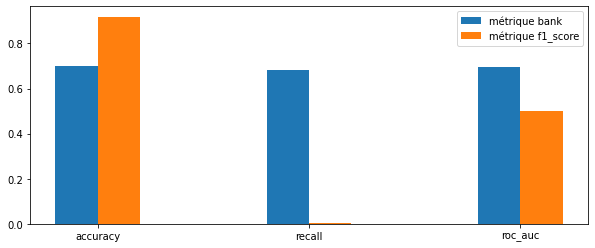

In [29]:
# Affichage des graphiques des scores : précisions, rappels, roc_auc
fig, ax = plt.subplots(1, figsize=(10, 4))

x = np.arange(3)  # the label locations
width = 0.2  # the width of the bars

ax.bar(x - width/2, scores_0, width, label='métrique bank')

ax.bar(x + width/2, scores_1, width, label='métrique f1_score')

ax.set_xticks(x)
ax.set_xticklabels(['accuracy', 'recall', 'roc_auc'])
ax.legend()
plt.show()

## Prédiction

Prédiction sur les données tests non étiquetées.    
Le modèle choisi est le `LGBMClassifier` et la métrique utilisée sera l'`Ind_bank`.

In [30]:
clf_0

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                 ('scaler', RobustScaler())])),
                ('regressor',
                 LGBMClassifier(colsample_bytree=0.8,
                                learning_rate=0.022417173924480838, max_depth=0,
                                n_estimators=1800, num_leaves=52, reg_alpha=0.4,
                                reg_lambda=0.30000000000000004,
                                subsample=0.6000000000000001))])

In [31]:
best_parameters_0

{'colsample_by_tree': 0.8,
 'learning_rate': 0.022417173924480838,
 'max_depth': 0.0,
 'n_estimators': 1800.0,
 'num_leaves': 52.0,
 'reg_alpha': 0.4,
 'reg_lambda': 0.30000000000000004,
 'solvability_threshold': 0.07500000000000001,
 'subsample': 0.6000000000000001}

In [32]:
feature_importance_0

,feature,importance
0,NAME_CONTRACT_TYPE,252
1,CODE_GENDER,406
2,FLAG_OWN_CAR,279
3,FLAG_OWN_REALTY,194
4,CNT_CHILDREN,200
...,...,...
233,WALLSMATERIAL_MODE_Monolithic,7
234,WALLSMATERIAL_MODE_Others,13
235,WALLSMATERIAL_MODE_Panel,74
236,"WALLSMATERIAL_MODE_Stone, brick",103


In [34]:
# Execution without the optimization
filename = '/content/drive/MyDrive/OC/Data/Data-P7/banking_model.pkl'
clf_0 = pickle.load(open(filename, 'rb'))
best_parameters_0 = {
    'colsample_by_tree': 0.7000000000000001,
    'learning_rate': 0.017587331061432714,
    'max_depth': 0.0,
    'n_estimators': 1400.0,
    'num_leaves': 44.0,
    'reg_alpha': 0.4,
    'reg_lambda': 0.9,
    'solvability_threshold': 0.1,
    'subsample': 0.6000000000000001
    }

In [ ]:
# Prédiction sur les données test
y_proba_test = clf_0.predict_proba(test_set.drop(columns=["TARGET", 'SK_ID_CURR']))[:, 1]
y_pred_test = (y_proba_test > best_parameters_0['solvability_threshold'])
y_pred_test = np.array(y_pred_test > 0) * 1

# On remplace les valeurs 'NaN' par les prédictions du modèle
test_set["TARGET"] = y_pred_test
app_no_encoded = app.copy()
app_test_no_encoded = app_no_encoded.loc[app_no_encoded["TARGET"].isna()]
app_test_no_encoded.loc[:, 'TARGET'] = test_set["TARGET"]

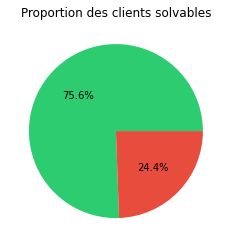

In [36]:
# Affichage de la proportion des clients solvables du test_set
plt.title("Proportion des clients solvables")
plt.pie(test_set["TARGET"].value_counts(),
       colors=["#2ecc71", "#e74c3c"],
       autopct='%1.1f%%',
       radius=1)
plt.show()

In [37]:
# Sauvegarde des prédictions
test_set.to_csv("app_test.csv")
!cp app_test.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

app_test_no_encoded.to_csv("app_test_no_encoded_no_featureengineering.csv")
!cp app_test_no_encoded_no_featureengineering.csv '/content/drive/MyDrive/OC/Data/Data-P7/'

## Importance des features

### Analyse globale des features

In [38]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
    """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (8, 4))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

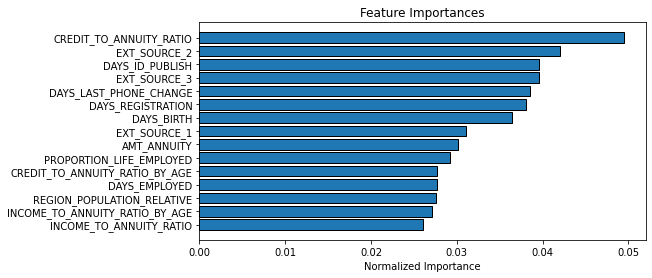

,index,feature,importance,importance_normalized
0,113,CREDIT_TO_ANNUITY_RATIO,4548,0.049542
1,32,EXT_SOURCE_2,3854,0.041983
2,13,DAYS_ID_PUBLISH,3636,0.039608
3,33,EXT_SOURCE_3,3631,0.039553
4,82,DAYS_LAST_PHONE_CHANGE,3539,0.038551
...,...,...,...,...
233,203,ORGANIZATION_TYPE_Religion,0,0.000000
234,180,ORGANIZATION_TYPE_Industry: type 1,0,0.000000
235,191,ORGANIZATION_TYPE_Industry: type 8,0,0.000000
236,189,ORGANIZATION_TYPE_Industry: type 6,0,0.000000


In [39]:
# Affichage de l'importance des features
plot_feature_importances(feature_importance_0)

### Analyse locale

**Clients similaires**

In [41]:
filename = '/content/drive/MyDrive/OC/Data/Data-P7/banking_model.pkl'
clf_0 = pickle.load(open(filename, 'rb'))

In [45]:
# Transformation du jeu test
x_test_transformed = pd.DataFrame(clf_0[0].transform(x_test.drop(columns=['SK_ID_CURR'])),
                          columns=x_test.drop(columns=['SK_ID_CURR']).columns,
                          index=x_test.index)

nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(x_test_transformed)

# On récupère l'indice des plus proches voisins du premier client de la table
indices = nbrs.kneighbors(x_test_transformed[0:1])[1].flatten()
app_no_encoded.iloc[indices]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Test,PROPORTION_LIFE_EMPLOYED,INCOME_TO_CREDIT_RATIO,INCOME_TO_ANNUITY_RATIO,INCOME_TO_ANNUITY_RATIO_BY_AGE,CREDIT_TO_ANNUITY_RATIO,CREDIT_TO_ANNUITY_RATIO_BY_AGE,INCOME_TO_FAMILYSIZE_RATIO
100002,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0.0,1.0,False,0.067329,0.498036,8.198215,-77563.308435,16.461104,-155738.505192,202500.0
137251,137251,0.0,Cash loans,M,N,Y,1,135000.0,816660.0,26473.5,...,0.0,2.0,False,0.209449,0.165307,5.099439,-83217.746048,30.848207,-503411.885093,45000.0
106099,106099,0.0,Cash loans,F,N,Y,1,76500.0,675000.0,19867.5,...,0.0,2.0,False,NaN,0.113333,3.850510,-84537.938845,33.975085,-745922.989807,25500.0
134406,134406,0.0,Cash loans,F,Y,N,2,157500.0,323388.0,34087.5,...,0.0,0.0,False,0.171907,0.487031,4.620462,-53486.468647,9.486997,-109821.473795,39375.0
106893,106893,0.0,Cash loans,F,N,N,1,135000.0,547344.0,27931.5,...,1.0,0.0,False,0.087945,0.246646,4.833253,-65234.412760,19.595940,-264486.403093,45000.0
140561,140561,0.0,Cash loans,M,N,N,0,81000.0,490536.0,15003.0,...,1.0,0.0,False,NaN,0.165125,5.398920,-116249.550090,32.695861,-704007.275345,40500.0
151236,151236,0.0,Cash loans,M,N,Y,2,180000.0,101880.0,12217.5,...,1.0,0.0,False,0.108195,1.766784,14.732965,-184103.130755,8.338858,-104202.372007,45000.0
110418,110418,0.0,Revolving loans,F,N,N,0,135000.0,135000.0,6750.0,...,0.0,1.0,False,0.172649,1.000000,20.000000,-161600.000000,20.000000,-161600.000000,135000.0
102610,102610,0.0,Revolving loans,F,N,Y,0,180000.0,675000.0,33750.0,...,0.0,1.0,False,0.087640,0.266667,5.333333,-115077.333333,20.000000,-431540.000000,180000.0
156242,156242,0.0,Cash loans,F,Y,Y,2,157500.0,797557.5,26356.5,...,1.0,5.0,False,0.267103,0.197478,5.975756,-62016.390644,30.260372,-314042.142735,39375.0


**Importance des features pour un client spécifique**

In [ ]:
lime1 = LimeTabularExplainer(x_test_transformed,
                             feature_names=x_test.columns,
                             class_names=["Solvable", "Non Solvable"],
                             discretize_continuous=False)
                            

exp = lime1.explain_instance(x_test_transformed.iloc[239],
                             clf_0.predict_proba,
                             num_samples=100)


In [58]:
# Id client
x_test_transformed.index[239]

101616

In [59]:
# Affichage des résultats
exp.show_in_notebook(show_table=True)

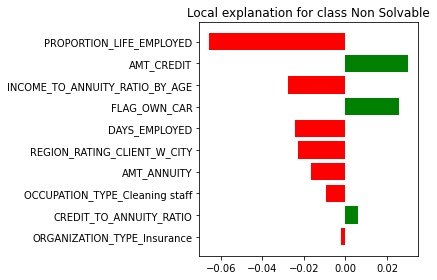

In [60]:
exp.as_pyplot_figure()
plt.tight_layout()